# Looking at changing family structures

*Overview of our project*

To do this, we need to use data from the census, which the first part of our project was dedicated to retrieving.

## Finding a package

We ended up going with the censusdata package. We found a clear write up about it at  https://towardsdatascience.com/accessing-census-data-with-python-3e2f2b56e20d and found it's functions clear and useful. We originally looked at the census package, but this required an api to access the data that often failed and the functions to get the data were less clear.

In [1]:
import pandas as pd
import censusdata

## Searching for relevant tables

This package contains a search function that allows us to search a data set for relevant tables.

In this search we looked at the American Community Survey 5-year estimates. This is a more in depth but slightly less accurate version of the 10 year census and is conducted on a rolling basis.

In this search we look at this data set for 2019 and look for tables related to marriage.

In [6]:
tables = censusdata.search('acs5', 2019,'concept', 'marriage')
print(len(tables))
tables[:3]

56


[('B12007A_001E',
  'MEDIAN AGE AT FIRST MARRIAGE (WHITE ALONE)',
  'Estimate!!Median age at first marriage --!!Male'),
 ('B12007A_002E',
  'MEDIAN AGE AT FIRST MARRIAGE (WHITE ALONE)',
  'Estimate!!Median age at first marriage --!!Female'),
 ('B12007B_001E',
  'MEDIAN AGE AT FIRST MARRIAGE (BLACK OR AFRICAN AMERICAN ALONE)',
  'Estimate!!Median age at first marriage --!!Male')]

This outputs a list of tuples with the code name, table name, and variable.

We then looked at a list of just the table names to be able to more easily look for the table we want.

In [5]:
table_names = list(set([row[1] for row in tables[:len(tables)-1]]))
table_names.sort()
table_names

['MARRIAGES ENDING IN WIDOWHOOD IN THE LAST YEAR BY SEX BY MARITAL STATUS FOR THE POPULATION 15 YEARS AND OVER',
 'MARRIAGES IN THE LAST YEAR BY SEX BY MARITAL STATUS FOR THE POPULATION 15 YEARS AND OVER',
 'MEDIAN AGE AT FIRST MARRIAGE',
 'MEDIAN AGE AT FIRST MARRIAGE (AMERICAN INDIAN AND ALASKA NATIVE ALONE)',
 'MEDIAN AGE AT FIRST MARRIAGE (ASIAN ALONE)',
 'MEDIAN AGE AT FIRST MARRIAGE (BLACK OR AFRICAN AMERICAN ALONE)',
 'MEDIAN AGE AT FIRST MARRIAGE (HISPANIC OR LATINO)',
 'MEDIAN AGE AT FIRST MARRIAGE (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)',
 'MEDIAN AGE AT FIRST MARRIAGE (SOME OTHER RACE ALONE)',
 'MEDIAN AGE AT FIRST MARRIAGE (TWO OR MORE RACES)',
 'MEDIAN AGE AT FIRST MARRIAGE (WHITE ALONE)',
 'MEDIAN AGE AT FIRST MARRIAGE (WHITE ALONE, NOT HISPANIC OR LATINO)',
 'MEDIAN DURATION OF CURRENT MARRIAGE IN YEARS BY SEX BY MARITAL STATUS FOR THE MARRIED POPULATION 15 YEARS AND OVER']

## Getting data froma specific table

We one we pick the name we needed to find the code

In [12]:
name = 'MEDIAN AGE AT FIRST MARRIAGE'
for item in tables:
    if item[1] == name:
        print(item)
        code = item[0][:6]
code

('B12007_001E', 'MEDIAN AGE AT FIRST MARRIAGE', 'Estimate!!Median age at first marriage --!!Male')
('B12007_002E', 'MEDIAN AGE AT FIRST MARRIAGE', 'Estimate!!Median age at first marriage --!!Female')


'B12007'

Then we can use the printtable function to get a look at the structure of the table.

In [13]:
censusdata.printtable(censusdata.censustable('acs5', 2019, code))

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B12007_001E  | MEDIAN AGE AT FIRST MARRIAGE   | !! !! Estimate Median age at first marriage -- Male      | float
B12007_002E  | MEDIAN AGE AT FIRST MARRIAGE   | !! !! Estimate Median age at first marriage -- Female    | float
-------------------------------------------------------------------------------------------------------------------


Then we can download the variables we choose into a pandas data frame by using the codes above.

In [18]:
marriage_age_2019 = censusdata.download('acs5', 2019,
                   censusdata.censusgeo([('state', '*')]),
                    ['B12007_001E', 'B12007_002E'])

,B12007_001E,B12007_002E
"Alabama: Summary level: 040, state:01",28.5,26.7
"Alaska: Summary level: 040, state:02",29.2,26.4
"Arizona: Summary level: 040, state:04",29.9,27.8
"Arkansas: Summary level: 040, state:05",27.2,25.7
"California: Summary level: 040, state:06",30.8,29.0


## Streamlining this process

To reformat this table and others, we wrote the following function. We can follow the same process to find other tables and variables of interest, and then plug that information into this function to get a nicer table.

In [94]:
"""
This function downloads the specified tables from the specified years and reformats them

Inputs: codes - a list of the table codes
        names - what to rename the variables for each table code
        years - years to get a table from
        
Output: one dataframe with the requested data compiling the different years
"""
def get_tables(codes, names, years):
    tables = []
    for year in years:
        #Get table
        df = censusdata.download('acs5', year,
                   censusdata.censusgeo([('state', '*')]),
                    codes)
        
        #Rename columns
        name_dict = dict(zip(codes, names))
        name_dict['index'] = 'State'
        df = df.reset_index() #Turns row names into row
        df = df.rename(columns = name_dict)
        
        #Shorten states column to state name
        df = df.astype({'State':'str'})
        df['State'] = df['State'].str.split(':').str.get(0) 
        
        #Add column for year
        df['Year'] = year
        
        tables.append(df)
    return pd.concat(tables)

In [96]:
marriage = get_tables(['B12007_001E', 'B12007_002E'], ['Male age', 'Female age'], [2009, 2014, 2019])

## Data visualization

Now we can make charts from the data.

In [82]:
from matplotlib import pyplot as plt

In [97]:
mar_cal = marriage[marriage['State'] == "California"]
mar_cal

,State,Male age,Female age,Year
4,California,28.8,26.8,2009
4,California,29.9,27.9,2014
4,California,30.8,29.0,2019


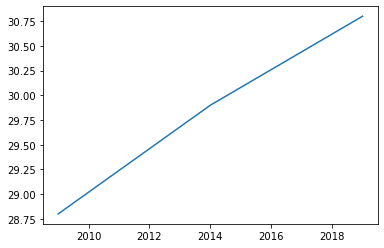

In [98]:
plt.plot(mar_cal['Year'], mar_cal['Male age'])